# **SMOTE = SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE**

## **Algorithm**

Train a KNN on minority class observation, find each observation 5 closest neighbours

**To Create the new synthetic data:**
- Select examples from the minority class at random
- Select a neighbour of each example at random (for the interpolation)
- Extract a random number between `0` and `1`
- Calculate the new example as:
  ```
  new_sample = (original_sample) - factor(original_sample - neighbour)
  ```
- The final dataset consists of the original dataset + the newly created examples

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
# Importing SMOTE Library
from imblearn.over_sampling import SMOTE

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate imbalanced dataset
n_samples_1 = 25  # Number of samples in class 1
n_samples_2 = 375  # Number of samples in class 2
centers = [(0, 0), (2, 2)]  # Centers of each cluster
cluster_std = [1.5, 1.5]  # Standard deviation of each cluster

X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


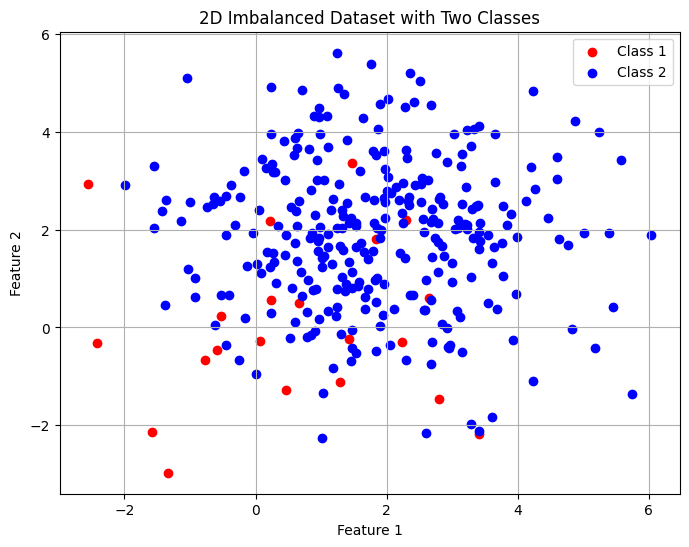

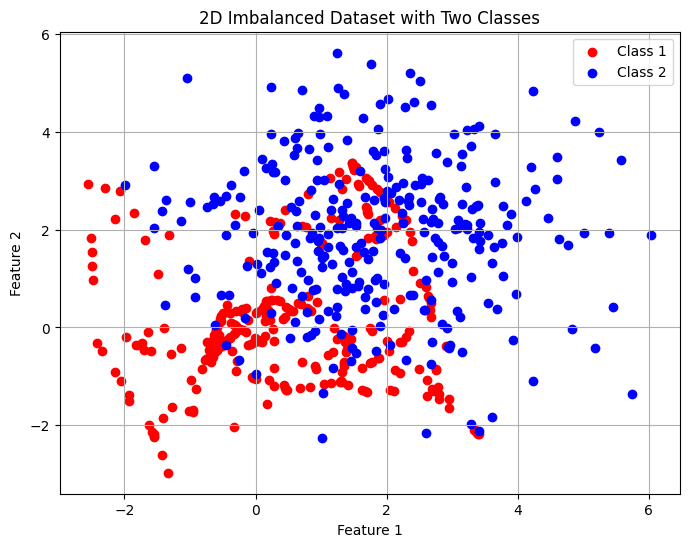

In [4]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 1')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 2')
plt.title('2D Imbalanced Dataset with Two Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_resampled_smote[y_resampled_smote == 0][:, 0], X_resampled_smote[y_resampled_smote == 0][:, 1], color='red', label='Class 1')
plt.scatter(X_resampled_smote[y_resampled_smote == 1][:, 0], X_resampled_smote[y_resampled_smote == 1][:, 1], color='blue', label='Class 2')
plt.title('2D Imbalanced Dataset with Two Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
print("Shape of the X_train: ", X_train.shape)
print("Resampling of the X_train: ", X_resampled_smote.shape)

print("Value Counts of Output (y_train): ", pd.Series(y_train).value_counts())
print()
print("Value Counts of Resampled Output (y_train): ", pd.Series(y_resampled_smote).value_counts())

Shape of the X_train:  (320, 2)
Resampling of the X_train:  (598, 2)
Value Counts of Output (y_train):  1    299
0     21
Name: count, dtype: int64

Value Counts of Resampled Output (y_train):  1    299
0    299
Name: count, dtype: int64


## From Logistic Regression

In [6]:
# Initialize and train LogisticRegression classifier on resampled data
classifier_smote = LogisticRegression()
classifier_smote.fit(X_resampled_smote, y_resampled_smote)

# Predict test set
y_pred_smote = classifier_smote.predict(X_test)
y_proba_smote = classifier_smote.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_smote))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_smote))

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.17      1.00      0.30         4
           1       1.00      0.75      0.86        76

    accuracy                           0.76        80
   macro avg       0.59      0.88      0.58        80
weighted avg       0.96      0.76      0.83        80

ROC AUC Score (With SMOTE): 0.950657894736842


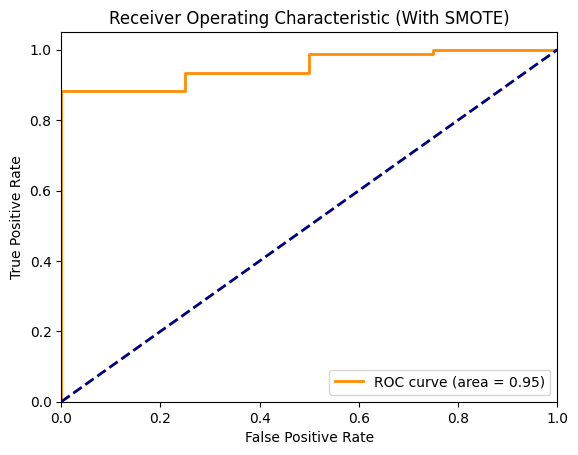

In [7]:
# Plotting ROC AUC Curve for SMOTE data
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)
plt.figure()
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_smote))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With SMOTE)')
plt.legend(loc="lower right")
plt.show()

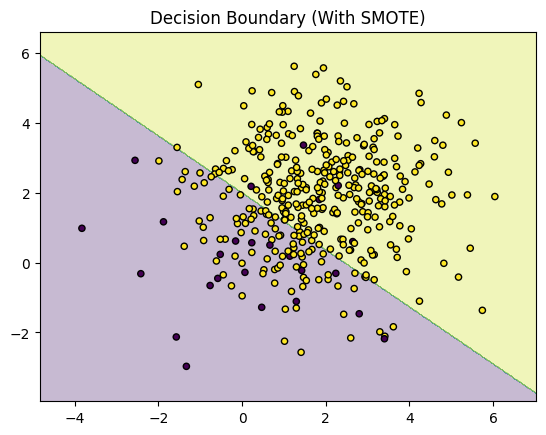

In [8]:
# Function to plot decision boundaries for SMOTE data
def plot_decision_boundaries_smote(X, y, model):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary (With SMOTE)")
    plt.show()

# Plot decision boundary for SMOTE data
plot_decision_boundaries_smote(X, y, classifier_smote)

## Using Balanced Random Forest Classifier : Ensemble Method

In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE
classifier = BalancedRandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict test set
y_pred_brf = classifier.predict(X_test)
y_proba_brf = classifier.predict_proba(X_test)[:, 1]

# Print classification report for SMOTE data
print("Classification Report (With SMOTE):")
print(classification_report(y_test, y_pred_brf))

# Print ROC AUC Score for SMOTE data
print("ROC AUC Score (With SMOTE):", roc_auc_score(y_test, y_proba_brf))

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

Classification Report (With SMOTE):
              precision    recall  f1-score   support

           0       0.16      0.75      0.26         4
           1       0.98      0.79      0.88        76

    accuracy                           0.79        80
   macro avg       0.57      0.77      0.57        80
weighted avg       0.94      0.79      0.85        80

ROC AUC Score (With SMOTE): 0.8519736842105262


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and w

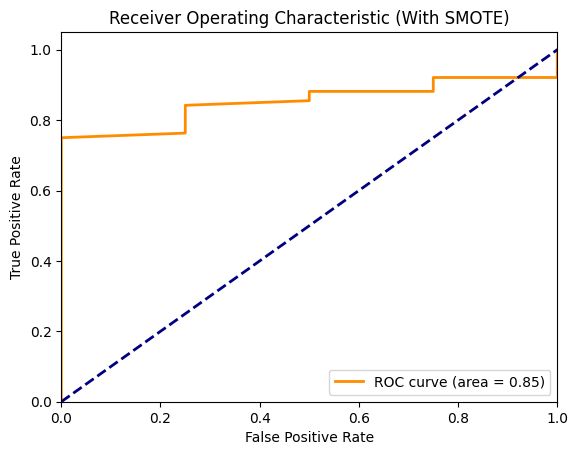

In [11]:
# Plotting ROC AUC Curve for SMOTE data
fpr_brf, tpr_brf, _ = roc_curve(y_test, y_proba_brf)
plt.figure()
plt.plot(fpr_brf, tpr_brf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba_brf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (With SMOTE)')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BalancedRandomForestClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


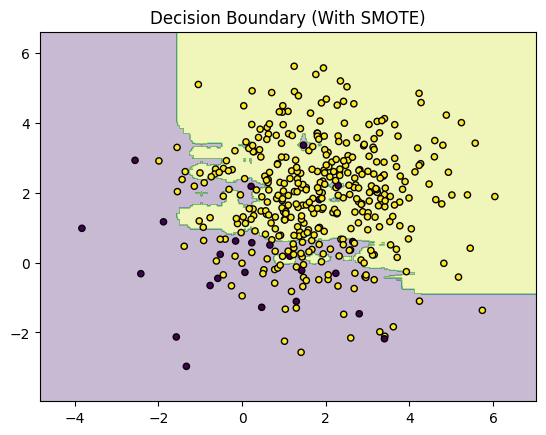

In [12]:
# Function to plot decision boundaries for SMOTE data
def plot_decision_boundaries_smote(X, y, model):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary (With SMOTE)")
    plt.show()

# Plot decision boundary for SMOTE data
plot_decision_boundaries_smote(X, y, classifier)

## Using Class Weights

Class weights are available only for those algorithms, whose generalization and loss can be defined

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression model with class weights
model = LogisticRegression(class_weight={0:50,1:1}, solver='liblinear')

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_proba = classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Print ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.09      1.00      0.16         7
           1       1.00      0.37      0.54       113

    accuracy                           0.41       120
   macro avg       0.54      0.69      0.35       120
weighted avg       0.95      0.41      0.52       120

ROC AUC Score: 0.9070796460176991


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The BalancedRandomForestClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


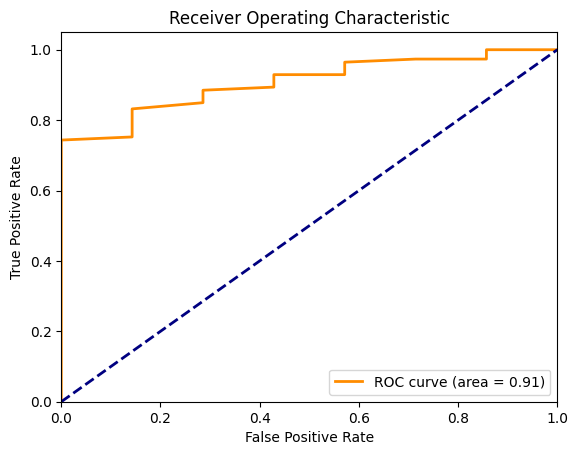

In [14]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

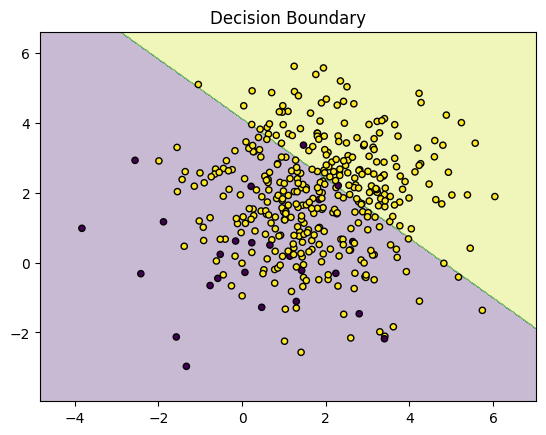

In [15]:
# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary")
    plt.show()

# Plot decision boundary
plot_decision_boundaries(X, y, model)

## Using Custom Loss Function

In [16]:
# Generate imbalanced dataset
n_samples_1 = 25  # Number of samples in class 1
n_samples_2 = 375  # Number of samples in class 2
centers = [(0, 0), (2, 2)]  # Centers of each cluster
cluster_std = [1.5, 1.5]  # Standard deviation of each cluster

X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=0)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def custom_loss(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))  # Convert to probability

    # Define penalties
    false_positive_penalty = 10
    false_negative_penalty = 1.0

    grad = (preds - labels) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    hess = preds * (1 - preds) * ((labels == 1) * false_negative_penalty + (labels == 0) * false_positive_penalty)
    return grad, hess

# Convert to DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'silent': 1,
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=10, obj=custom_loss)

# Predict test set
y_pred = np.where(bst.predict(dtest) > 0.5, 1, 0)
y_proba = bst.predict(dtest)  # Probability predictions

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print ROC AUC Score
auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.57      0.27         7
           1       0.97      0.83      0.90       113

    accuracy                           0.82       120
   macro avg       0.57      0.70      0.58       120
weighted avg       0.92      0.82      0.86       120

ROC AUC Score: 0.7319848293299621


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


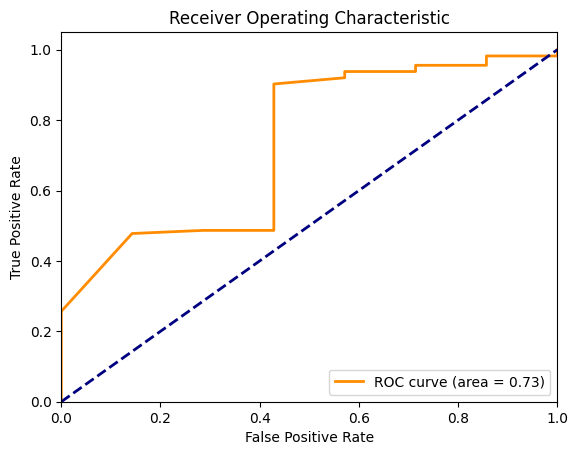

In [17]:
# Plotting ROC AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

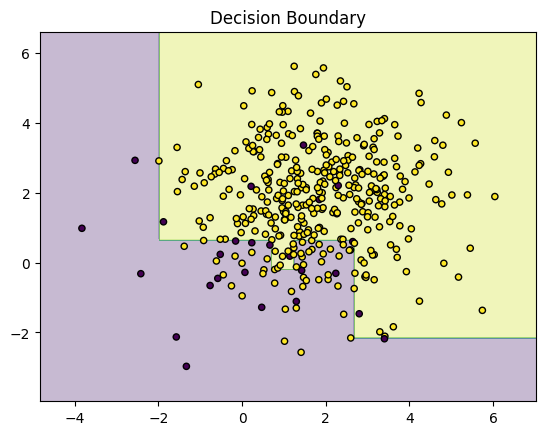

In [18]:
def plot_decision_boundaries(X, y, model):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = model.predict(xgb.DMatrix(np.c_[xx.ravel(), yy.ravel()]))
    Z = np.where(Z > 0.5, 1, 0).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=20)
    plt.title("Decision Boundary")
    plt.show()

# Plot decision boundary
plot_decision_boundaries(X, y, bst)